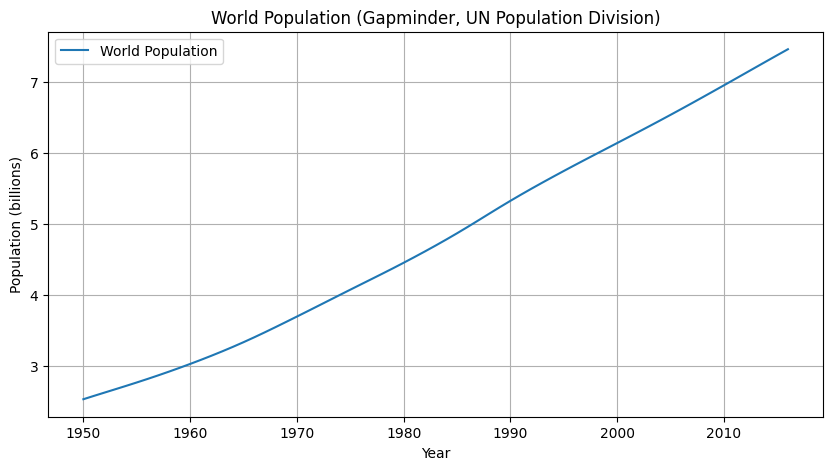

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pop = pd.read_csv("../data/Total population - Gapminder, UN Population Division.csv")

col_pop = "Total population (Gapminder, UN Population Division)"
world_pop = pop[pop["Entity"]=="World"][["Year", col_pop]].rename(columns={col_pop:"population"})

# Plot
plt.figure(figsize=(10,5))
plt.plot(world_pop["Year"], world_pop["population"] / 1e9, label="World Population")
plt.xlabel("Year")
plt.ylabel("Population (billions)")
plt.title("World Population (Gapminder, UN Population Division)")
plt.legend()
plt.grid(True)
plt.show()


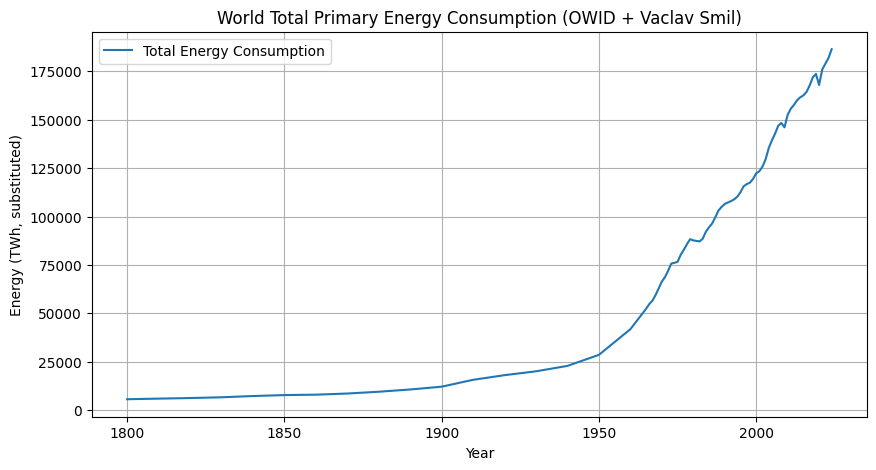

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file from your local data folder
energy = pd.read_csv("../data/global-energy-substitution.csv")

# Compute total energy by summing all sources
energy["total_energy_twh"] = energy[[
    "Other renewables (TWh, substituted energy)",
    "Biofuels (TWh, substituted energy)",
    "Solar (TWh, substituted energy)",
    "Wind (TWh, substituted energy)",
    "Hydropower (TWh, substituted energy)",
    "Nuclear (TWh, substituted energy)",
    "Gas (TWh, substituted energy)",
    "Oil (TWh, substituted energy)",
    "Coal (TWh, substituted energy)",
    "Traditional biomass (TWh, substituted energy)"
]].sum(axis=1)

# Keep only World aggregate
world_energy = energy[energy["Entity"]=="World"][["Year","total_energy_twh"]]

# Plot
plt.figure(figsize=(10,5))
plt.plot(world_energy["Year"], world_energy["total_energy_twh"], label="Total Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Energy (TWh, substituted)")
plt.title("World Total Primary Energy Consumption (OWID + Vaclav Smil)")
plt.legend()
plt.grid(True)
plt.show()


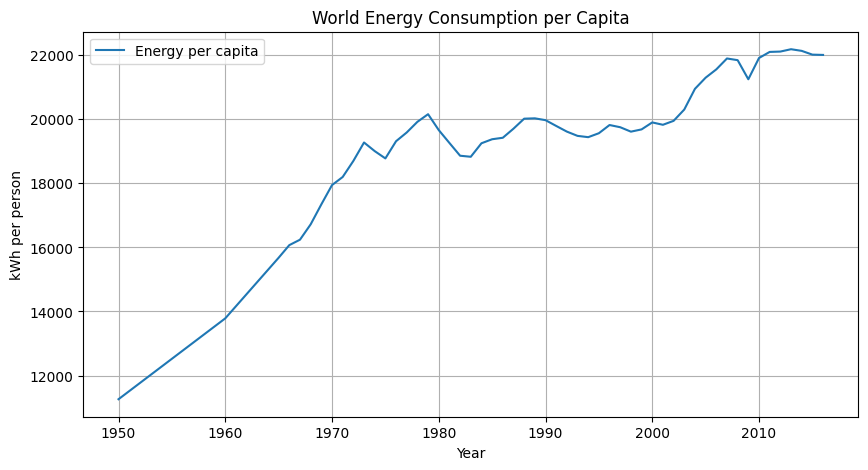

,Year,total_energy_twh,population,energy_per_capita_kwh
0,1950,28564.000000,2.536275e+09,11262.187071
1,1960,41813.888900,3.033212e+09,13785.348062
2,1965,52355.588381,3.339593e+09,15677.237622
3,1966,54772.235836,3.408122e+09,16071.092016
4,1967,56501.968140,3.479054e+09,16240.613396
5,1968,59384.887910,3.551881e+09,16719.279970
6,1969,62882.805912,3.625905e+09,17342.649307
7,1970,66406.371675,3.700578e+09,17944.865750
8,1971,68710.882797,3.775791e+09,18197.744765
9,1972,72017.685071,3.851545e+09,18698.386917


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load population (already in memory as world_pop)
# world_pop: columns = [Year, population]

# Load energy
energy = pd.read_csv("../data/global-energy-substitution.csv")

energy["total_energy_twh"] = energy[[
    "Other renewables (TWh, substituted energy)",
    "Biofuels (TWh, substituted energy)",
    "Solar (TWh, substituted energy)",
    "Wind (TWh, substituted energy)",
    "Hydropower (TWh, substituted energy)",
    "Nuclear (TWh, substituted energy)",
    "Gas (TWh, substituted energy)",
    "Oil (TWh, substituted energy)",
    "Coal (TWh, substituted energy)",
    "Traditional biomass (TWh, substituted energy)"
]].sum(axis=1)

world_energy = energy[energy["Entity"]=="World"][["Year","total_energy_twh"]]

# Merge with population
df = pd.merge(world_energy, world_pop, on="Year", how="inner")

# Compute per capita energy in kWh
df["energy_per_capita_kwh"] = (df["total_energy_twh"] * 1e9) / df["population"]

# Plot
plt.figure(figsize=(10,5))
plt.plot(df["Year"], df["energy_per_capita_kwh"], label="Energy per capita")
plt.xlabel("Year")
plt.ylabel("kWh per person")
plt.title("World Energy Consumption per Capita")
plt.legend()
plt.grid(True)
plt.show()

df.head(15)


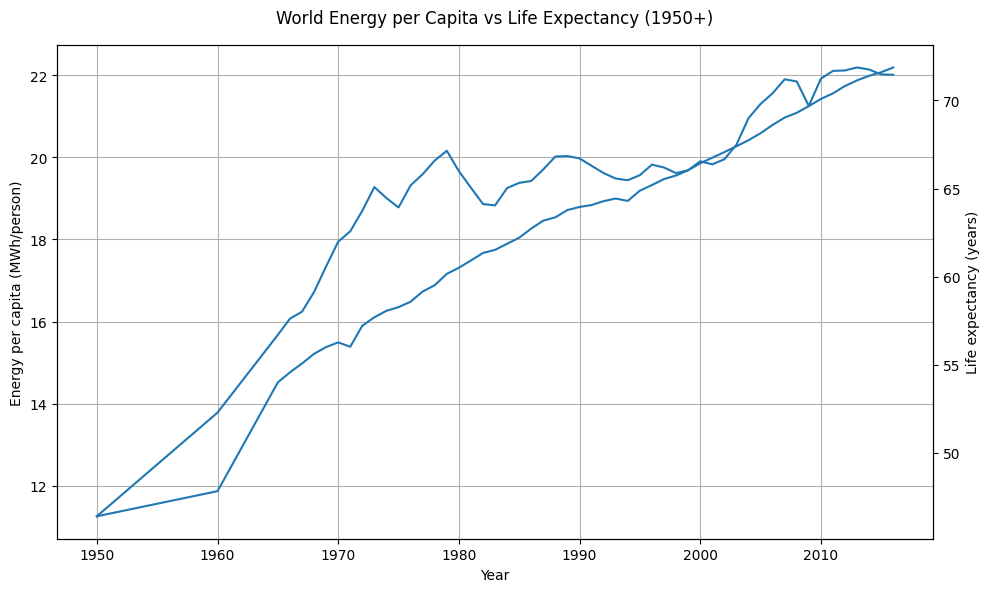

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load your life expectancy file (adjust path) ---
life = pd.read_csv("../data/life-expectancy.csv")

# Normalize column names (strip + lowercase for matching)
life.columns = [c.strip() for c in life.columns]

# Helper to find a column by keywords (case-insensitive)
def find_col(cols, *needles):
    lc = [c.lower() for c in cols]
    for c in cols:
        cl = c.lower()
        if all(n in cl for n in needles):
            return c
    return None

# Identify key columns even if names differ
entity_col = find_col(life.columns, "entity") or find_col(life.columns, "country") or find_col(life.columns, "location") or "Entity"
year_col   = find_col(life.columns, "year") or "Year"
life_col   = (
    find_col(life.columns, "life", "expect") or
    find_col(life.columns, "life", "years") or
    find_col(life.columns, "expectancy")
)

if life_col is None:
    raise ValueError(f"Could not find the life expectancy column. Columns are: {list(life.columns)}")

# Filter World series & keep from 1950
world_life = (
    life[life[entity_col].str.strip().str.lower() == "world"]
      [[year_col, life_col]]
      .rename(columns={year_col: "Year", life_col: "life_expectancy"})
)
world_life = world_life[world_life["Year"] >= 1950]

# --- Assume you already have df with energy per capita from earlier (1950+) ---
# df columns: Year, energy_per_capita_kwh (or energy_per_capita_mwh), population
# If you have kWh/person, add MWh/person for nicer scale:
if "energy_per_capita_mwh" not in df.columns and "energy_per_capita_kwh" in df.columns:
    df["energy_per_capita_mwh"] = df["energy_per_capita_kwh"] / 1000

# Merge
df_full = pd.merge(df, world_life, on="Year", how="inner").sort_values("Year")

# --- Plot dual axis: Energy per capita (MWh/person) vs Life expectancy (years) ---
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(df_full["Year"], df_full["energy_per_capita_mwh"], label="Energy per capita (MWh/person)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Energy per capita (MWh/person)")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(df_full["Year"], df_full["life_expectancy"], label="Life expectancy (years)")
ax2.set_ylabel("Life expectancy (years)")

fig.suptitle("World Energy per Capita vs Life Expectancy (1950+)")
fig.tight_layout()
plt.show()



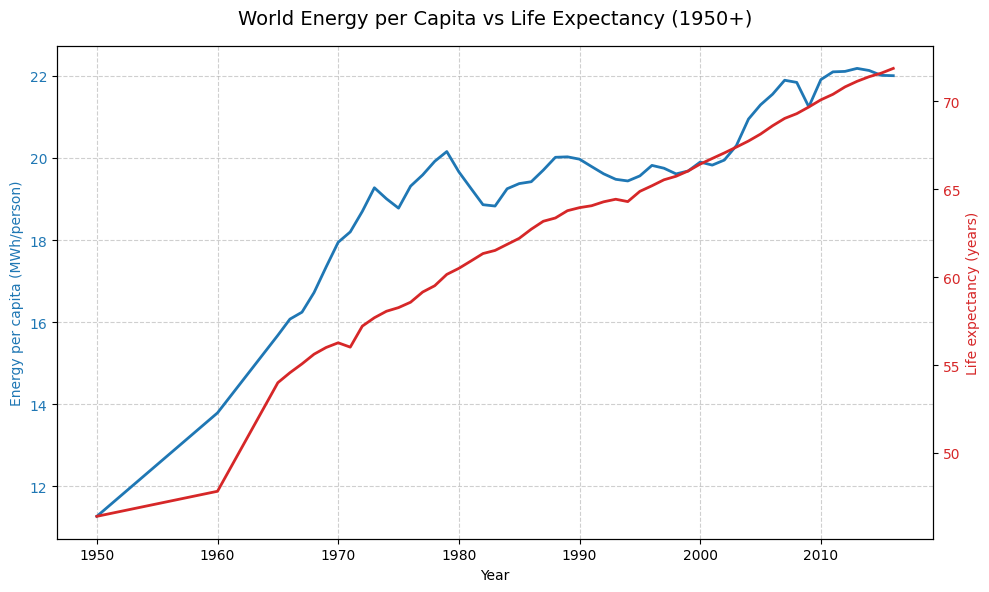

In [16]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Left axis: Energy per capita
ax1.plot(
    df_full["Year"], df_full["energy_per_capita_mwh"],
    color="tab:blue", linewidth=2, label="Energy per capita (MWh/person)"
)
ax1.set_xlabel("Year")
ax1.set_ylabel("Energy per capita (MWh/person)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, linestyle="--", alpha=0.6)

# Right axis: Life expectancy
ax2 = ax1.twinx()
ax2.plot(
    df_full["Year"], df_full["life_expectancy"],
    color="tab:red", linewidth=2, label="Life expectancy (years)"
)
ax2.set_ylabel("Life expectancy (years)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title
fig.suptitle("World Energy per Capita vs Life Expectancy (1950+)", fontsize=14)

# Save as PNG
plt.tight_layout()
plt.savefig("energy_vs_life_expectancy.png", dpi=300)
plt.show()
